In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1.2962e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (((2*x*(h1)))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (((2 * x * (h2)))-(4 * h1)) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (((2*x*(h3)))-(6*h2)) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (((2 * x * h4)) - (8 * h3)) / (2**(5/2) * (np.pi**(1/4)) * np.sqrt(math.factorial(5)))

#FROM THIS ON NO MODIFICATION ON WEIGHTS
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

2024-04-10 12:10:36.398046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 12:10:36.886473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Latest modification (04/10/24)

2024-04-10 12:10:37.851862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   128       ['input_1[0][0]']             
                                                                                                  
 h1_layer (H1Layer)          (None, 64)                   64        ['dense[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 64)                   4160      ['h1_layer[0][0]']            
                                                                                              

2024-04-10 12:10:37.870980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 12:10:37.871172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 12:10:37.873354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2024-04-10 12:10:40.276466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 12:10:40.277734: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f883279dfc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 12:10:40.277745: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-10 12:10:40.280989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 12:10:40.403984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-10 12:10:40.497184: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 3s 4ms/step - loss: 0.4939 - val_loss: 0.5166
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4939 - val_loss: 0.5166
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4938 - val_loss: 0.5166
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.4511 - val_loss: 0.2996
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1112 - val_loss: 0.0245
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0185 - val_loss: 0.0115
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0059
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.0132
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0018
E

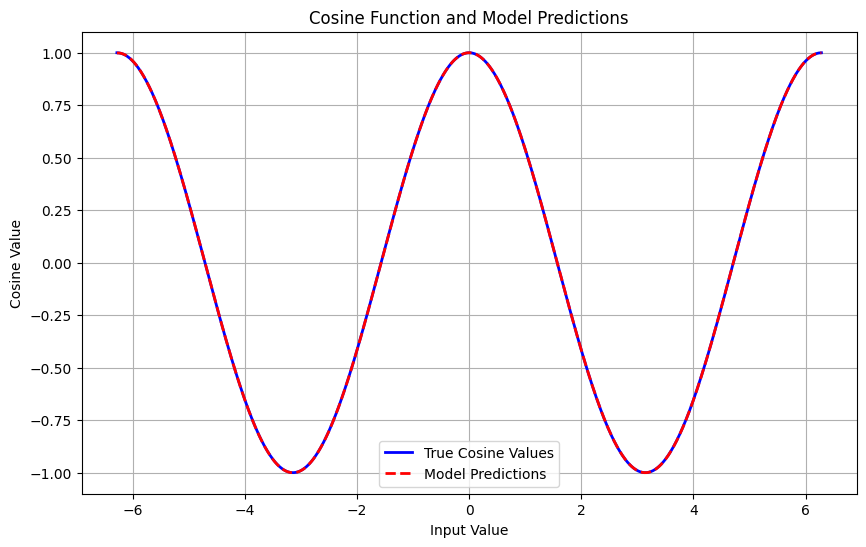

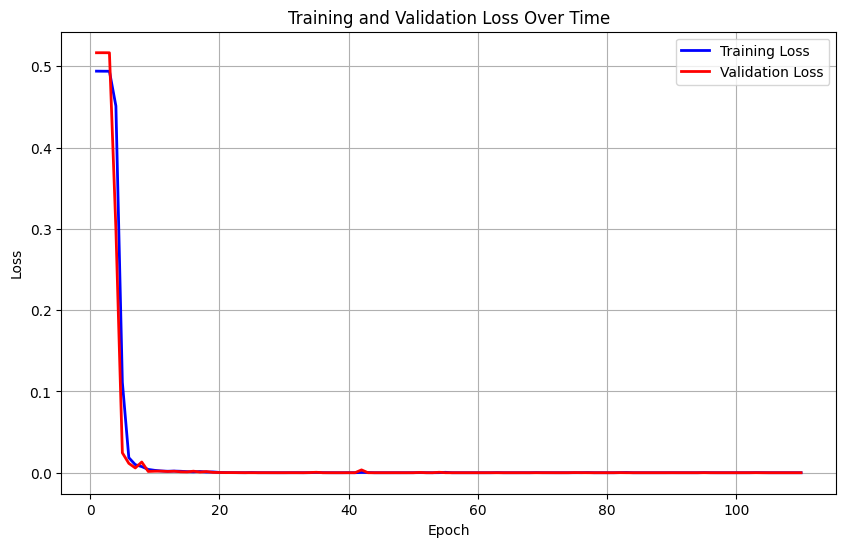

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = -2 * np.pi
upper_bound = 2 * np.pi
# lower_bound = -10
# upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    h6 = H6Layer()

    x = Dense(filters)(x)
    x = x_h1 = h1(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h4 = h4(x,x_h2, x_h3)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h5 = h5(x,x_h3, x_h4)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h6 = h6(x,x_h4, x_h5)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()
#59 SECONDS

## 1D Example np.exp(-2*x) * np.cos(5*np.pi*x) + x

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   128       ['input_1[0][0]']             
                                                                                                  
 h1_layer (H1Layer)          (None, 64)                   64        ['dense[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 64)                   4160      ['h1_layer[0][0]']            
                                                                                              

2024-03-25 13:34:16.789349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 13:34:16.809138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 13:34:16.809338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2024-03-25 13:34:19.275325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-25 13:34:19.276690: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7247cdaa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 13:34:19.276702: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-25 13:34:19.279980: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-25 13:34:19.395267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-25 13:34:19.480528: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 3s 4ms/step - loss: 0.2385 - val_loss: 0.1882
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1609 - val_loss: 0.1265
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1246 - val_loss: 0.1252
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1226 - val_loss: 0.1221
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1193 - val_loss: 0.1193
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1186 - val_loss: 0.1201
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1183 - val_loss: 0.1193
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1183 - val_loss: 0.1186
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1183 - val_loss: 0.1186
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1183 - val_loss: 0.1197
E

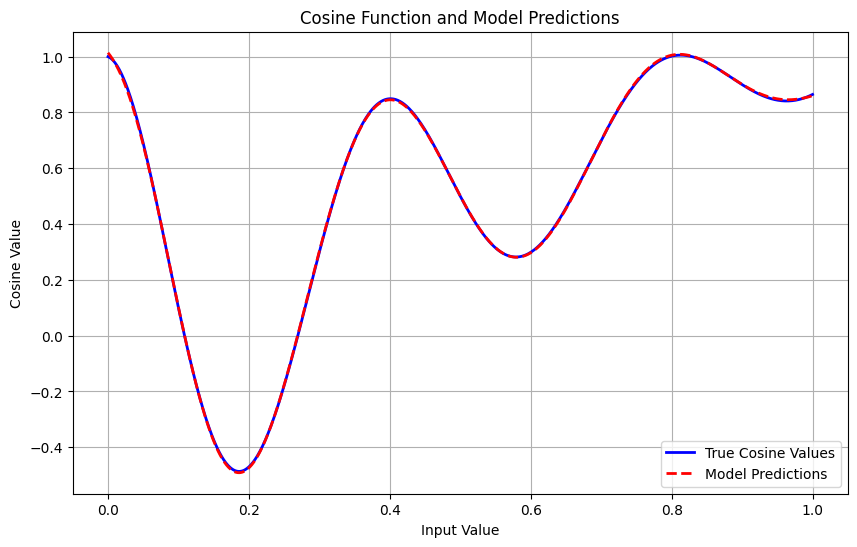

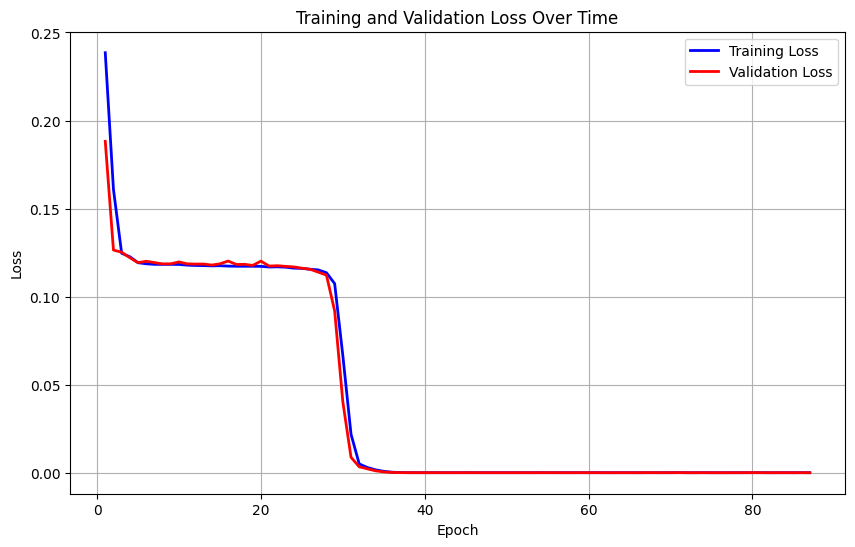

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = 0
upper_bound = 1
# lower_bound = -10
# upper_bound = 10
def custom_function(x):
    return np.exp(-2*x) * np.cos(5*np.pi*x) + x

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = custom_function(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()

    x = Dense(filters)(x)
    x = x_h1 = h1(x)
    # x = h1(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    # x = h2(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    # x = h3(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = x_h4 = h4(x,x_h2, x_h3)
    # x = h4(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = h5(x, x_h3, x_h4)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

y_true = custom_function(X_test)

y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()
#38.4 SECONDS


# OLD VERSION FOR np.exp(-2*x) * np.cos(5*np.pi*x) + x

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization,Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import keras.backend as K


class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

callback = StopAtThresholdCallback(threshold=1e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 

class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)
    
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_7 (Dense)             (None, 64)                128       
                                                                 
 h2_layer_1 (H2Layer)        (None, 64)                64        
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 tensor_decomposition_layer  (None, 64)                384       
  (TensorDecompositionLayer                                      
 )                                                               
                                                                 
 h3_layer_1 (H3Layer)        (None, 64)                64  

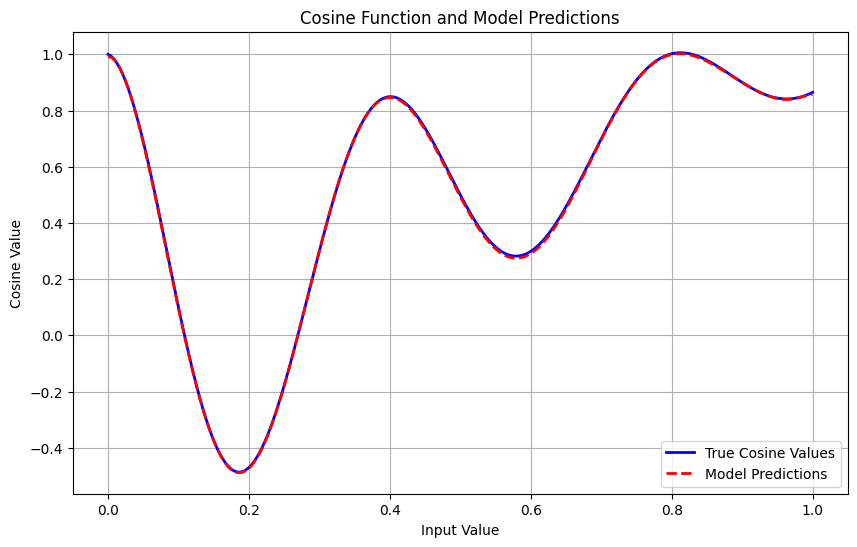

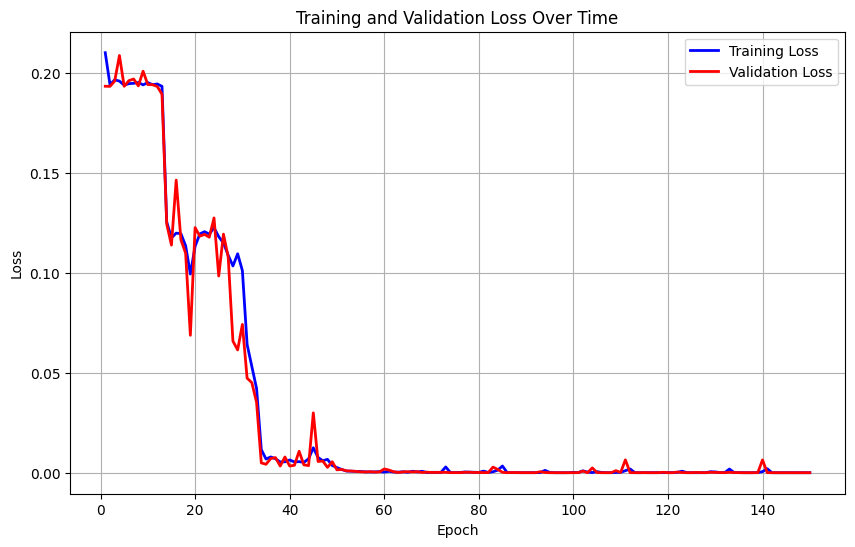

In [4]:
np.random.seed(42)
n_samples = 10000
lower_bound = 0
upper_bound = 1
# lower_bound = -10
# upper_bound = 10
def custom_function(x):
    return np.exp(-2*x) * np.cos(5*np.pi*x) + x

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = custom_function(X)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

y_true = custom_function(X_test)

y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()

## Normalized one

In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1.2962e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (((2*x*(self.h1(x))))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (((2 * x * (self.h2(x))))-(4 * self.h1(x))) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (((2*x*(self.h3(x))))-(6*self.h2(x))) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (((2 * x * h4)) - (8 * h3)) / (2**(5/2) * (np.pi**(1/4)) * np.sqrt(math.factorial(5)))

#FROM THIS ON NO MODIFICATION ON WEIGHTS
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

2024-04-10 12:27:02.787901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 12:27:03.288806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 h2_layer (H2Layer)          (None, 64)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 h3_layer (H3Layer)          (None, 64)                64        
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 h4_layer (H4Layer)          (None, 64)                64    

2024-04-10 12:27:04.299477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 12:27:04.318417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 12:27:04.318673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2024-04-10 12:27:06.817990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 12:27:06.819663: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f74b1009190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 12:27:06.819675: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-10 12:27:06.822927: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 12:27:06.942979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-10 12:27:07.034030: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

125/125 [==============================] - 3s 4ms/step - loss: 0.2027 - val_loss: 0.1931
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1921 - val_loss: 0.1947
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1933 - val_loss: 0.1942
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1934 - val_loss: 0.1930
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1956 - val_loss: 0.1958
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1936 - val_loss: 0.1932
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1926 - val_loss: 0.1937
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1919 - val_loss: 0.1803
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1235 - val_loss: 0.1039
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.0599
E

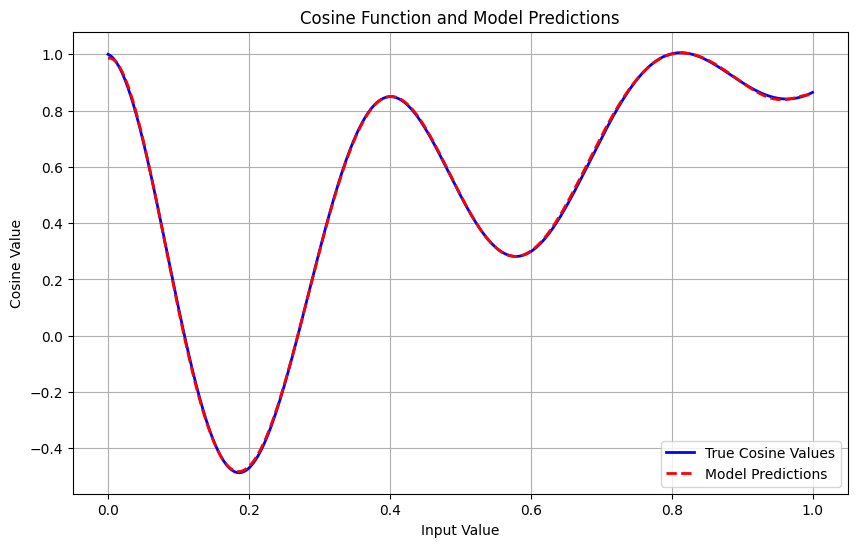

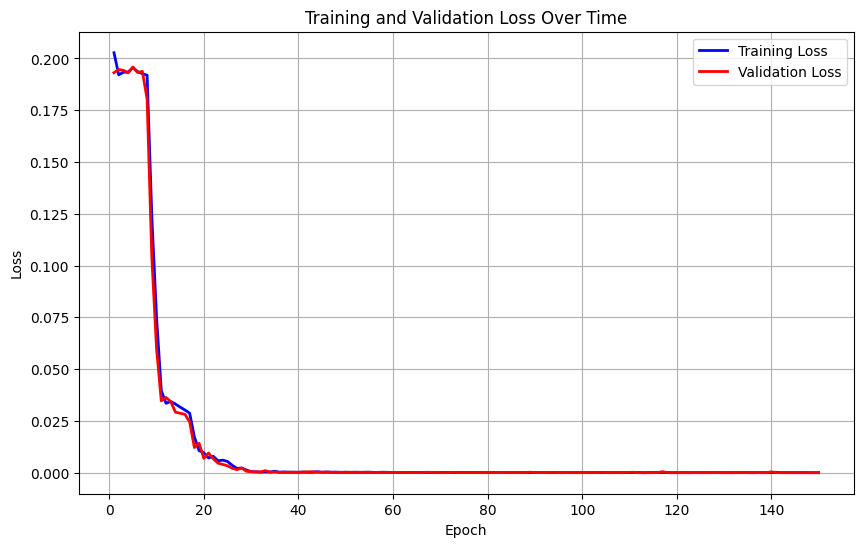

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = 0
upper_bound = 1
# lower_bound = -10
# upper_bound = 10
def custom_function(x):
    return np.exp(-2*x) * np.cos(5*np.pi*x) + x

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = custom_function(X)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)
    x = Dense(filters)(x)
    x = h2(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

y_true = custom_function(X_test)

y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()